## Import library


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

## Define the Neural Network

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

## Training Process

In [26]:
def train_vae(model, train_loader, optimizer, epochs=10, device='cuda'):
    """
    Training loop for the VAE.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            data = data.view(data.size(0), -1)
            
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)
            
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average loss = {avg_loss:.4f}')

## Define Loss function

In [28]:
def loss_function(recon_x, x, mu, log_var):
    """
    Computes the VAE loss function.
    """
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

In [29]:
# Example usage
def plot_results(model, test_loader, num_examples=10, device='cuda'):
    """
    Plot original images, their reconstructions, and generated samples
    """
    plt.figure(figsize=(15, 5))
    
    # Get some test examples
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            if batch_idx == 0:
                data = data.to(device)
                data_flat = data.view(data.size(0), -1)
                
                # Get reconstructions
                recon_batch, mu, log_var = model(data_flat)
                recon_batch = recon_batch.view(-1, 1, 28, 28)
                
                # Plot original images
                for i in range(num_examples):
                    plt.subplot(3, num_examples, i + 1)
                    plt.imshow(data[i][0].cpu().numpy(), cmap='gray')
                    plt.axis('off')
                    if i == 0:
                        plt.title('Original')
                
                # Plot reconstructed images
                for i in range(num_examples):
                    plt.subplot(3, num_examples, i + 1 + num_examples)
                    plt.imshow(recon_batch[i][0].cpu().numpy(), cmap='gray')
                    plt.axis('off')
                    if i == 0:
                        plt.title('Reconstructed')
                
                # Generate and plot random samples
                sample = torch.randn(num_examples, model.fc_mu.out_features).to(device)
                sample = model.decode(sample).view(-1, 1, 28, 28)
                for i in range(num_examples):
                    plt.subplot(3, num_examples, i + 1 + 2*num_examples)
                    plt.imshow(sample[i][0].cpu().numpy(), cmap='gray')
                    plt.axis('off')
                    if i == 0:
                        plt.title('Generated')
                
                plt.tight_layout()
                plt.show()
                break

In [30]:
def generate_samples(model, num_samples=10, device='cuda'):
    """
    Generate samples from the trained VAE.
    """
    with torch.no_grad():
        sample = torch.randn(num_samples, model.fc_mu.out_features).to(device)
        generated = model.decode(sample)
        return generated

In [24]:
# Example usage
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=128,
        shuffle=True
    )
    
    # Initialize model and optimizer
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Train the model
    train_vae(model, train_loader, optimizer, epochs=10, device=device)
    
    # Generate samples
    samples = generate_samples(model, num_samples=10, device=device)
    
    # Create test loader
    test_loader = DataLoader(
        dataset=torchvision.datasets.MNIST(
            root='./data',
            train=False,
            transform=transform,
            download=True
        ),
        batch_size=128,
        shuffle=True
    )
    
    # Plot results
    plot_results(model, test_loader, num_examples=10, device=device)

    return model, samples

Epoch 1: Average loss = 164.3877
Epoch 2: Average loss = 121.9536
Epoch 3: Average loss = 114.8755
Epoch 4: Average loss = 111.9071
Epoch 5: Average loss = 110.0571
Epoch 6: Average loss = 108.8997
Epoch 7: Average loss = 108.0461
Epoch 8: Average loss = 107.3297
Epoch 9: Average loss = 106.8608
Epoch 10: Average loss = 106.3845


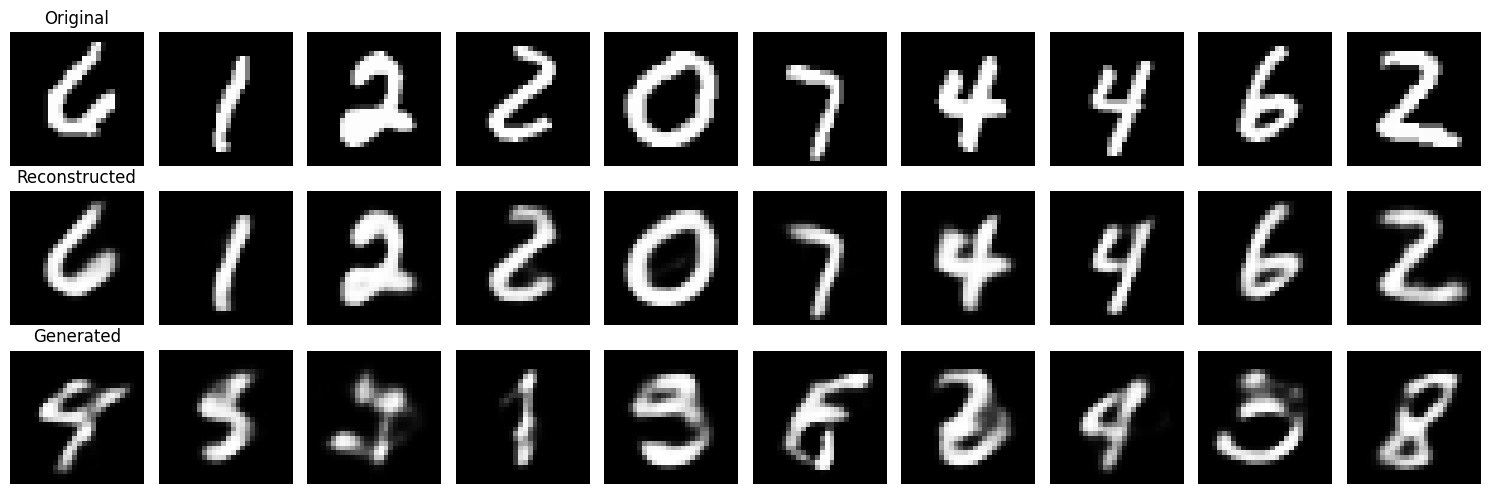

In [25]:
if __name__ == "__main__":
    main()